# Data analysis of single patient

## Table of Contents: <a class="anchor" id="toc"></a>
* [Notebook setup](#setup)
* [Plots of VCGs](#vcg_plots)
* [Exploration of basic (spatial) features](#basic_explore)
  * [Colour coded plots to look for patterns ourselves](#ccplots)
  * [PCA](#pcaplots)
    * [PCA using original data frame](#pcaorig)
    * [Visualising principal components](#pcavis)
    * [PCA using only temporal data](#pcatemp)
    * [PCA using both temporal and spatial data](#pcaboth)
    * [PCA using spatial information in the principal plane](#pcaplane)
    * [Visualising planar principal components](#pcaplanevis)
  * [Kernel PCA](#kpcaplots)
  * [Isomaps](#isoplots)
  * [Do patients cluster by dyssynchrony](#clusterdys)
  * [Simulation parameters](#simpplots)
  * [Statistical moments](#smplots)
  * [Other parameters](#otherpplots)
* [Machine learning for prediction of dyssynchrony](#main_ml)
  * [Linear discriminant analysis](#lda)
  * [Kernel ridge regression](#krr)
    * [Using only spatial information](#krr_spat)
    * [Using spatial and temporal information](#krr_temp)
    * [Using only statistical moments](#krr_sm)

## Notebook setup <a class="anchor" id="setup"></a>
[To table of contents](#toc)

### Basic imports

In [103]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import numpy.linalg as la
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from data_parser import parse, parse_all
from data_modification import *
from visualization.plot_vcg import plot_vcg_axes, plot_3d_vcg, create_cmap, multivariate_scatter, univariate_scatter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.decomposition import KernelPCA, PCA
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notebook parameters

In [159]:
patient_no = [0, 1, 2, 4, 5]
data_path = 'C:/Users/bruker/Documents/Programming/Simula/LBBB_LVdyssync'
resample = True
use_principal_axes = True
use_cylindrical = False # Some visualisation functions will not work if this is true
resampling_no = 500

### Load data

In [160]:
patient = normalise_patient(parse_all(initial_path=data_path, patient_number=patient_no))
patient = resample_add_velocity_patient(patient, length=resampling_no, mode=3) if resample else patient
patient = project_patient(patient) if use_principal_axes else patient
patient_center = center_patient(patient)
patient_cyl = cylindrical_patient(patient_center)

### Create data matrix

In [165]:
dyssyncs = patient['desync'].copy()
dm = create_data_matrix(patient_cyl, transforms=[None, np.cos, None]) if use_cylindrical else create_data_matrix(patient)


# Randomize order of dataset
ind = np.arange(dm.shape[0])
np.random.shuffle(ind)
dyssyncs = dyssyncs[ind]
dm = dm[ind, :]


dm = dm[dyssyncs != 0]
dyssyncs_clean = dyssyncs[dyssyncs != 0]

# Get offset vector:
mean_vals = dm.mean(axis=0, keepdims=True)

# Center data matrix:
dm_center = dm - mean_vals


# Same but with temporal information
patientv = normalise_patient(parse_all(initial_path=data_path, patient_number=patient_no))
patientv = cylindrical_patient(patientv) if use_cylindrical else patientv

matricesv = [
    np.array(resample_by_velocity(vcg, length=resampling_no, velosi=True)).T
                   for vcg in patientv['vcg_model']
]
for matrix in matricesv:
    matrix[:, 1] = np.cos(matrix[:, 1])
dyssyncsv = patientv['desync'].copy()


vectors = [np.concatenate(matrix, axis=0).reshape([-1, 1]) for matrix in matricesv]
dmv = np.concatenate(vectors, axis=1).T

dmv = dmv[ind]
dyssyncsv = dyssyncsv[ind]

dmv = dmv[dyssyncsv != 0]
dyssyncsv = dyssyncsv[dyssyncsv != 0]
dmv_center = dmv - dmv.mean(axis=0)

# Compute statistical moments
dyssyncs_sm = patientv['desync'].copy()
sm = np.zeros((len(dyssyncs_sm), 24))
for i, matrix in enumerate(matricesv):
    # Spatial information first
    df_temp = pd.DataFrame(matrix[:, :3])
    sm[i, :3] = df_temp.mean()
    sm[i, 3:6] = df_temp.std()
    sm[i, 6:9] = df_temp.kurtosis()
    sm[i, 9:12] = df_temp.skew()
    
    # Then temporal information
    df_temp = pd.DataFrame(matrix[:, 3:])
    sm[i, 12:15] = df_temp.mean()
    sm[i, 15:18] = df_temp.std()
    sm[i, 18:21] = df_temp.kurtosis()
    sm[i, 21:24] = df_temp.skew()

# Real VCG:
patient_sm = np.zeros(24)
matrix = np.array(resample_by_velocity(patientv['vcg_real'], length=500, velosi=True)).T
df_temp = pd.DataFrame(matrix[:, 3])
sm[i, :3] = df_temp.mean()
sm[i, 3:6] = df_temp.std()
sm[i, 6:9] = df_temp.kurtosis()
sm[i, 9:12] = df_temp.skew()
df_temp = pd.DataFrame(matrix[:, 3:])
sm[i, 12:15] = df_temp.mean()
sm[i, 15:18] = df_temp.std()
sm[i, 18:21] = df_temp.kurtosis()
sm[i, 21:24] = df_temp.skew()

dyssyncs_sm = dyssyncs_sm[ind]
sm = sm[ind]
sm = sm[dyssyncs_sm != 0]
dyssyncs_sm = dyssyncs_sm[dyssyncs_sm != 0]
sm_center = sm - sm.mean(0)

### Basic plotting settings

In [166]:
cmap = create_cmap(
    dataset = dyssyncs[dyssyncs != 0],
    cmap = 'viridis'
)

## Plots of VCGs <a class="anchor" id="vcg_plots"></a>
[To table of contents](#toc)

This section is just here to get familiar with the data and do basic data exploration

### 3D plots of heart vectors

<IPython.core.display.Javascript object>


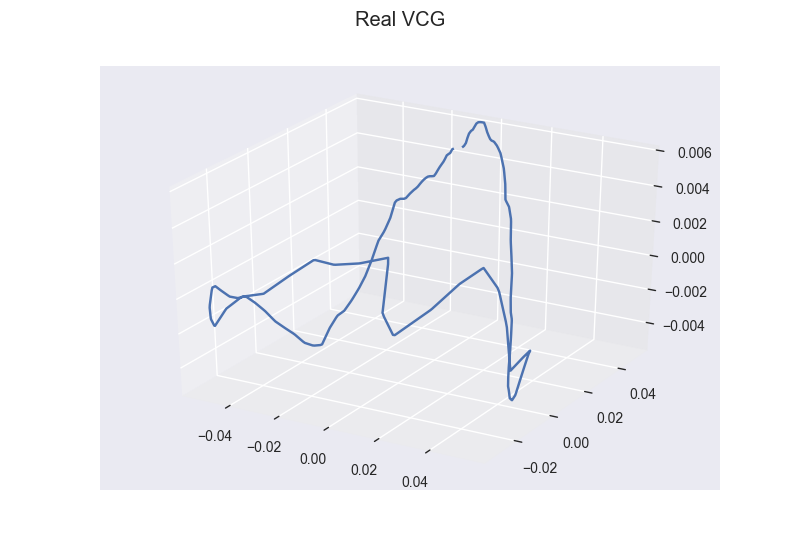

In [167]:
fig, _, _ = plot_3d_vcg(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

In [121]:
fig_3dvcg, ax_3dvcg, wire_3dvcg = plot_3d_vcg(np.array(patient['vcg_model'][281]))
fig_3dvcg.suptitle('Modelled VCG no 0')

pat_slider_3dvcg = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button_3dvcg = widgets.Button(description='Plot VCG')

def replot_3dvcg(click):
    global fig_3dvcg, ax_3dvcg, wire_3dvcg, pat_slider_3dvcg
    fig_3dvcg, ax_3dvcg, wire_3dvcg = plot_3d_vcg(
        np.array(patient['vcg_model'][pat_slider_3dvcg.value]), 
        figure=fig_3dvcg, 
        axes=ax_3dvcg, 
        wire=wire_3dvcg
    )
    fig_3dvcg.suptitle('Modelled VCG no{}'.format(pat_slider_3dvcg.value))
    
plot_button_3dvcg.on_click(replot_3dvcg)

display(pat_slider_3dvcg, plot_button_3dvcg)

<IPython.core.display.Javascript object>

## VCG's in cartesian coordinates

In [122]:
fig, _, _, = plot_vcg_axes(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>

In [123]:
fig_2dvcg, ax_2dvcg, plots_2dvcg = plot_vcg_axes(np.array(patient['vcg_model'][0]))
fig.suptitle('Modelled VCG no 0')
pat_slider_2dvcg = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button_2dvcg = widgets.Button(description='Plot VCG')

def replot_2dvcg(click):
    global fig_2dvcg, ax_2dvcg, plots_2dvcg, pat_slider_2dvcg
    plot_vcg_axes(
        np.array(patient['vcg_model'][pat_slider_2dvcg.value]),
        figure=fig_2dvcg, 
        axes=ax_2dvcg, 
        plots=plots_2dvcg
    )
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button_2dvcg.on_click(replot_2dvcg)
display(pat_slider_2dvcg, plot_button_2dvcg)

<IPython.core.display.Javascript object>

## VCGs in cylindrical coordinates
### After centering

<IPython.core.display.Javascript object>


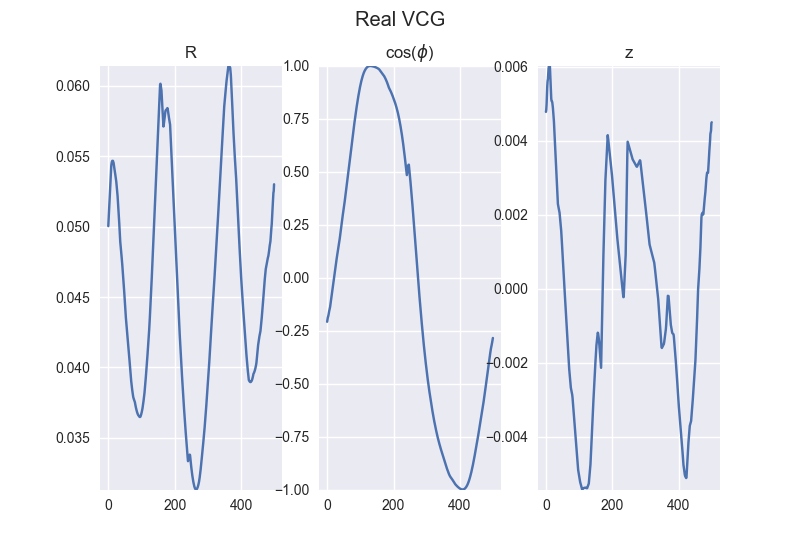

In [189]:
transforms = [None, lambda x: np.cos(x), None]
fig, _, _, = plot_vcg_axes(np.array(patient_cyl['vcg_real']), titles=['R', 'cos($\phi$)', 'z'], transforms=transforms)
fig.suptitle('Real VCG')

In [125]:
transforms = [None, lambda x: np.cos(x), None]
fig_cylvcg, ax_cylvcg, plots_cylvcg = plot_vcg_axes(np.array(patient_cyl['vcg_model'][0]), titles=['R', '$cos(\phi)$', 'z'], transforms=transforms)
fig.suptitle('Modelled VCG no 0')
pat_slider_cylvcg = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button_cylvcg = widgets.Button(description='Plot VCG')

def replot_cylvcg(click):
    global fig_cylvcg, ax_cylvcg, plots_cylvcg, pat_slider_cylvcg
    plot_vcg_axes(
        np.array(patient_cyl['vcg_model'][pat_slider_cylvcg.value]), 
        figure=fig_cylvcg, 
        axes=ax_cylvcg, 
        plots=plots_cylvcg, 
        titles=['R', 'cos($\phi$)', 'z'], 
        transforms=transforms
    )
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button_cylvcg.on_click(replot_cylvcg)
display(pat_slider_cylvcg, plot_button_cylvcg)

<IPython.core.display.Javascript object>

## Exploration of basic features vs dyssynchrony <a class="anchor" id="basic_explore"></a>

### Color coded plots <a class="anchor" id="ccplots"></a>
[To table of contents](#toc)
#### To see if we can find any patterns in the data ourselves

In [126]:
# General properties for plotting
transforms = [None, lambda x: np.cos(x), None]

In [188]:
fig, axes, plots = fig, ax, plots = plot_vcg_axes(
    vcg = np.array(patient_cyl['vcg_model'][0]), 
    color = cmap.to_rgba(dyssyncs[0]),
    titles = ['R', '$cos(\phi)$', 'z'], 
    transforms = transforms
)

for dyssync, simulation in zip(dyssyncs, patient_cyl['vcg_model']):
    simulation = np.array(simulation)
    color = np.array(cmap.to_rgba(dyssync))
    color[3] = 0.1
    fig, axes, _ = plot_vcg_axes(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        titles = ['R', '$cos(\phi)$', 'z'],
        transforms = transforms,
        set_lims=False
    )

axes[0].set_ylim(0, 1)
axes[2].set_ylim(-.4, .4)

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

## 3D plots - not much info here

In [128]:
color = np.array(cmap.to_rgba(dyssyncs[0]))
color[3] = 0.4
fig, axes, _ = plot_3d_vcg(np.array(patient_center['vcg_model'][0]), color=color, set_lims=False)

min_x, min_y, min_z = [np.float('inf')]*3
max_x, max_y, max_z = [-np.float('inf')]*3
for dyssync, simulation in zip(dyssyncs[0::10], patient_center['vcg_model'][0::10]):
    if dyssync == 0:
        continue
    # Set min and max
    min_x = min(np.min(simulation['px']), min_x)
    min_y = min(np.min(simulation['py']), min_y)
    min_z = min(np.min(simulation['pz']), min_z)
    
    max_x = max(np.max(simulation['px']), max_x)
    max_y = max(np.max(simulation['py']), max_y)
    max_z = max(np.max(simulation['pz']), max_z)
    
    simulation = np.array(simulation)
    color = np.array(cmap.to_rgba(dyssync))
    color[3] = 0.4 
    fig, axes, _ = plot_3d_vcg(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        set_lims=False
    )

axes.set_xlim(min_x, max_x)
axes.set_ylim(min_y, max_y)
axes.set_zlim(min_z, max_z)

<IPython.core.display.Javascript object>

(-0.30501735169023553, 0.36401712070705855)

## PCA scatter plot <a class="anchor" id="pcaplots"></a>
[To table of contents](#toc)

### PCA using only spatial components<a class="anchor" id="pcaorig"></a>
[To table of contents](#toc)

Note: If the data frame isn't resampled, this will also use temporal information.

<IPython.core.display.Javascript object>


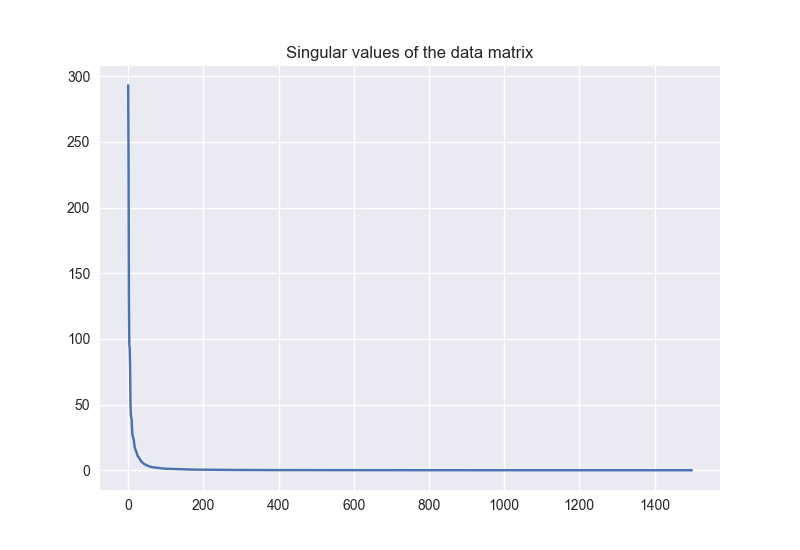

<IPython.core.display.Javascript object>


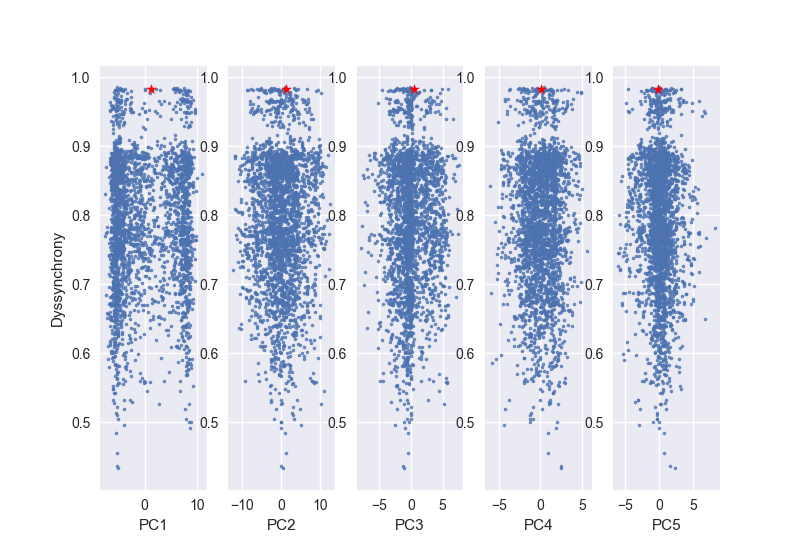

<IPython.core.display.Javascript object>


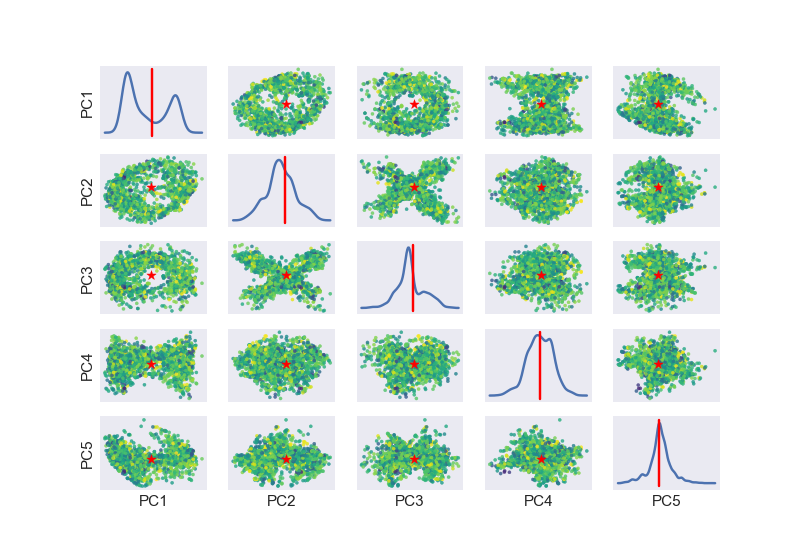

In [168]:
# Compute principal components:
U, S, V = np.linalg.svd(dm_center[:, :])

plt.figure()
plt.plot(S)
plt.title('Singular values of the data matrix')

# Coordinate change
pca_matrix = dm_center[:, :].dot(V.T)
if use_cylindrical:
    patient_vector = np.reshape(patient_cyl['vcg_real'].values, [-1])
else:
    patient_vector = np.reshape(patient['vcg_real'].values, [-1])

pca_real = (patient_vector - mean_vals)[:, :].dot(V.T)[0]

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_clean.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_clean,
    real_point = pca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    real_point = pca_real
)

### Visualising principal components<a class="anchor" id="pcavis"></a>
[To table of contents](#toc)

Projecting a signal down to a principal axis can be interpreted as a measure of similarity between the signal and the principal component corresponding to that axis. It is possible to visualise the principal components by plotting the curves they are equivalent to. This will give us an idea of what these axes actually represent.

NOTE: This cell must be ran directly after previous cell

<IPython.core.display.Javascript object>


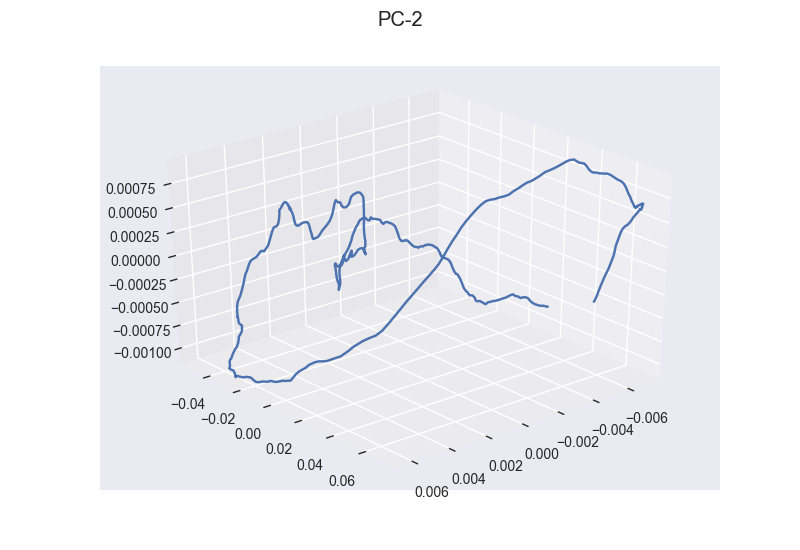

In [169]:
if use_cylindrical:
    raise ValueError('Cannot visualise principal components in cylindrical coordinates')
fig_pca, ax_pca, wire_pca = plot_3d_vcg(V[0, :].reshape([-1, 3]))
V_visualise = V.copy()
fig_pca.suptitle('PC-0')

pat_slider_pca = widgets.IntSlider(0, 0, len(V), description='PC no:')
plot_button_pca = widgets.Button(description='Plot PC')

def replot_pca(click):
    global fig_pca, ax_pca, wire_pca, pat_slider_pca
    fig_pca, ax_pca, wire_pca = plot_3d_vcg(
        np.array(V_visualise[pat_slider_pca.value, :].reshape([-1, 3])), 
        figure=fig_pca, 
        axes=ax_pca, 
        wire=wire_pca
    )
    fig_pca.suptitle('PC-{}'.format(pat_slider_pca.value))
    
plot_button_pca.on_click(replot_pca)

display(pat_slider_pca, plot_button_pca)


### PCA using only temporal information<a class="anchor" id="pcatemp"></a>
[To table of contents](#toc)

<IPython.core.display.Javascript object>


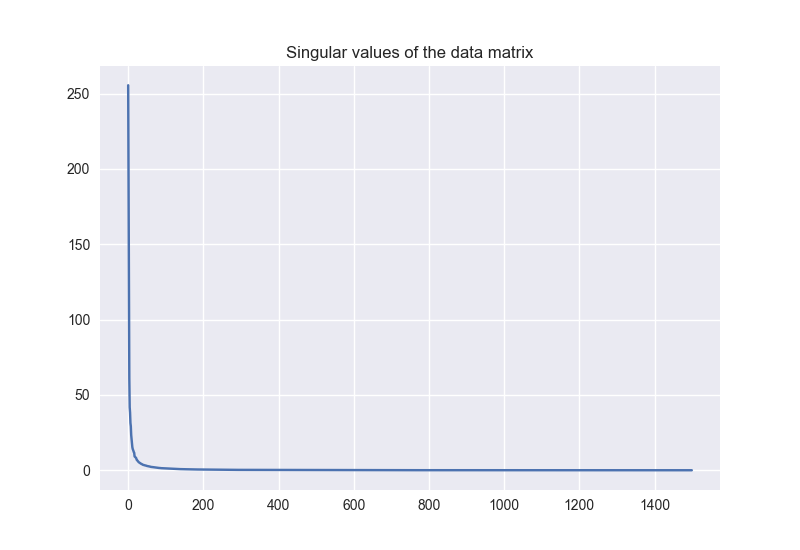

<IPython.core.display.Javascript object>


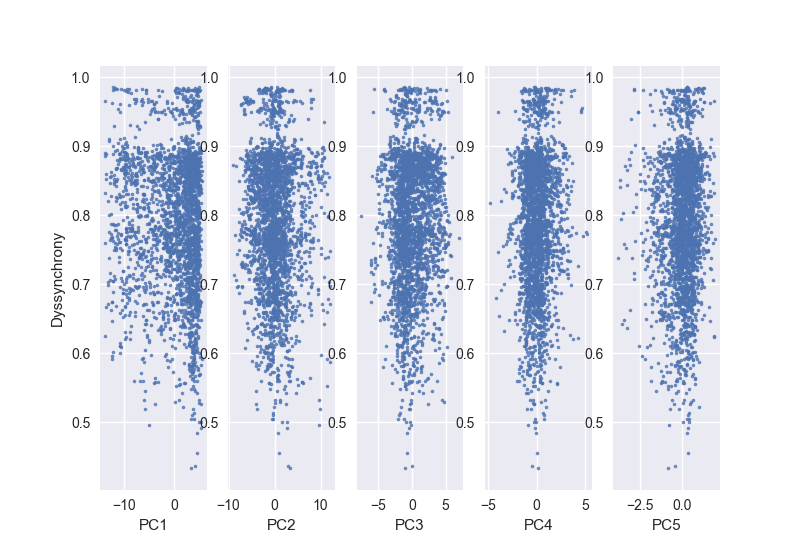

<IPython.core.display.Javascript object>


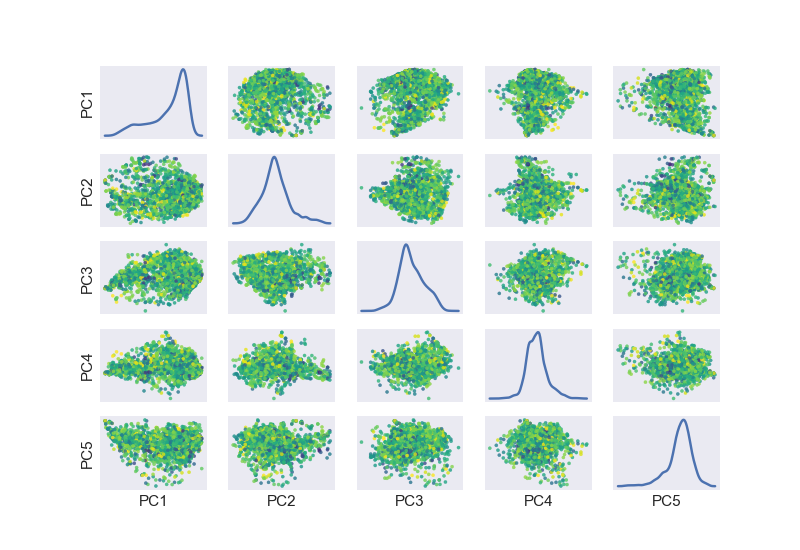

In [170]:
# Compute principal components:
U, S, V = np.linalg.svd(dmv_center[:, 1500:])

plt.figure()
plt.plot(S)
plt.title('Singular values of the data matrix')

# Coordinate change
pca_matrix = dmv_center[:, 1500:].dot(V.T)
patient_vector = np.reshape(patient_cyl['vcg_real'].values, [np.prod(patient_cyl['vcg_real'].values.shape)])

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_clean.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_clean,
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
)

### PCA using both spatial and temporal information<a class="anchor" id="pcaboth"></a>
[To table of contents](#toc)

<IPython.core.display.Javascript object>


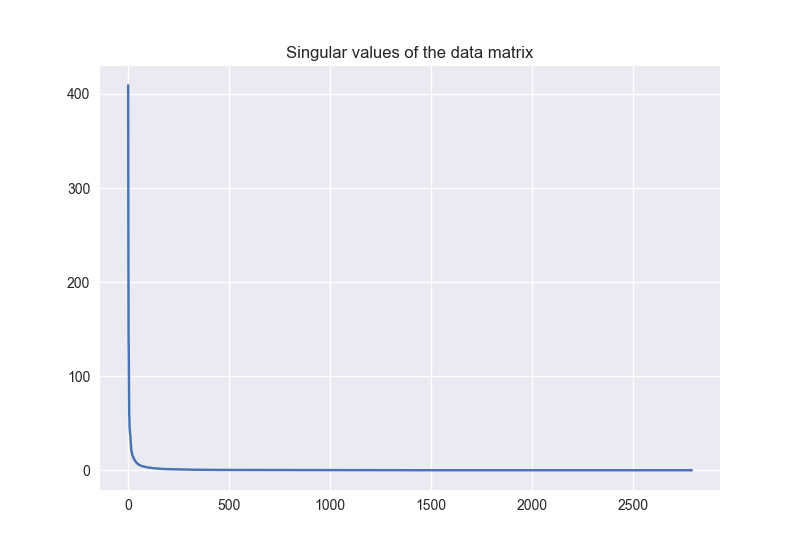

<IPython.core.display.Javascript object>


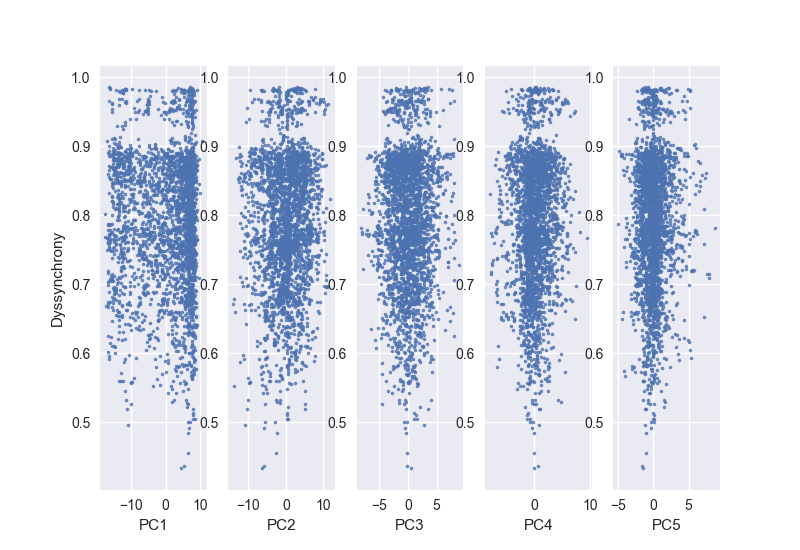

<IPython.core.display.Javascript object>


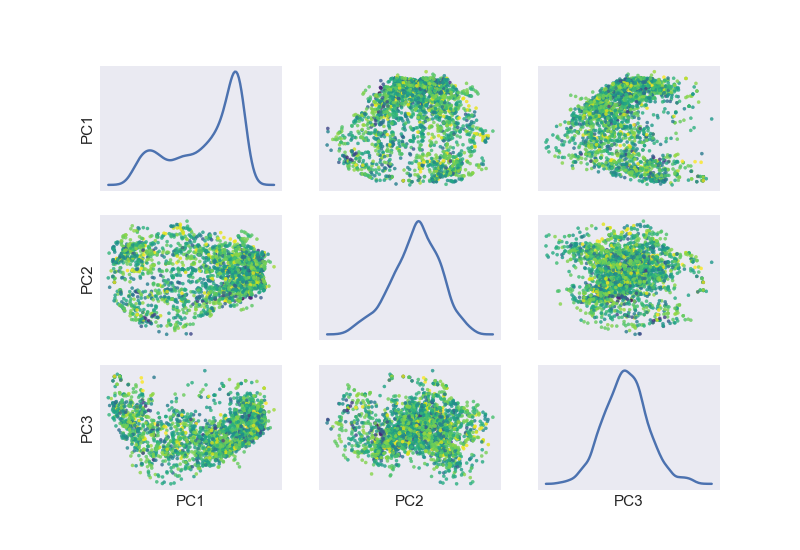

In [190]:
# Compute principal components:
U, S, V = np.linalg.svd(dmv_center[:, :])

plt.figure()
plt.plot(S)
plt.title('Singular values of the data matrix')

# Coordinate change
pca_matrix = dmv_center[:, :].dot(V.T)
patient_vector = np.reshape(patient_cyl['vcg_real'].values, [np.prod(patient_cyl['vcg_real'].values.shape)])

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_clean.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_clean,
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 3,
    colour_by = 'Dyssynchrony',
)

### PCA Using spatial information in the plane<a class="anchor" id="pcaplane"></a>
[To table of contents](#toc)

In [133]:
# Compute principal components:

dm2d = np.concatenate((dm_center[:, ::3], dm_center[:, 1::3]), axis=1)
U2d, S2d, V2d = np.linalg.svd(dm2d[:, :])

plt.figure()
plt.plot(S2d)
plt.title('Singular values of the data matrix')

# Coordinate change
pca_matrix_2d = dm2d[:, :].dot(V2d.T)
if use_cylindrical:
    patient_vector = np.reshape(patient_cyl['vcg_real'].values, [-1])
else:
    patient_vector = np.reshape(patient['vcg_real'].values, [-1])

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix_2d.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix_2d, dyssyncs_clean.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_clean,
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony'
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualising planar principal components<a class="anchor" id="pcaplanevis"></a>
[To table of contents](#toc)

Projecting a signal down to a principal axis can be interpreted as a measure of similarity between the signal and the principal component corresponding to that axis. It is possible to visualise the principal components by plotting the curves they are equivalent to. This will give us an idea of what these axes actually represent.

NOTE: This cell must be ran directly after previous cell

In [134]:
fig_2dpca = plt.figure()
ax_2dpca = fig_2dpca.add_subplot(111)
plot_2dpca = ax_2dpca.plot(V2d[:5, :resampling_no].sum(0), V2d[:5, resampling_no:].sum(0))[0]
pat_slider_2dpca = widgets.IntSlider(0, 0, len(V), description='PC no:')
pca_sliders = [widgets.FloatSlider(min=0, max=1, step=0.1, value=0.5, description='PC{}'.format(i)) for i in range(5)]
plot_button_2dpca = widgets.Button(description='Plot PC')

def replot_2dpca(click):
    global fig_2dpca, ax_2dpca, plot_2dpca, pat_slider_2dpca, pca_slideres
    xdata = np.zeros(resampling_no)
    ydata = np.zeros(resampling_no)
    for i, slider in enumerate(pca_sliders):
        xdata += slider.value*V2d[i, :resampling_no]
        ydata += slider.value*V2d[i, resampling_no:]
    plot_2dpca.set_data(xdata, ydata)
    ax_2dpca.set_xlim(xdata.min(), xdata.max())
    ax_2dpca.set_ylim(ydata.min(), ydata.max())
        
plot_button_2dpca.on_click(replot_2dpca)
display(*pca_sliders)
display(plot_button_2dpca)

<IPython.core.display.Javascript object>

## Kernel PCA <a class="anchor" id="kpcaplots"></a>
[To table of contents](#toc)

In [135]:
gamma = 0.0008


kpca = KernelPCA(kernel='rbf', gamma=gamma)

X_kpca = kpca.fit_transform(dm_center)

if use_cylindrical:
    patient_vector = np.reshape(patient_cyl['vcg_real'].values, [-1])
else:
    patient_vector = np.reshape(patient['vcg_real'].values, [-1])

kpca_real = kpca.transform((patient_vector - mean_vals))[0]

column_titles = ['K-PC{}'.format(i+1) for i in range(X_kpca.shape[1])] + ['Dyssynchrony']
kpca_df = pd.DataFrame(
    np.concatenate([X_kpca, dyssyncs_clean.reshape([dyssyncs_clean.shape[0], 1])], axis=1), 
    columns = column_titles
)

In [136]:
univariate_scatter(
    data_frame = kpca_df,
    dyssynchrony = dyssyncs_clean,
    real_point = kpca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)


plt.figure(plt.get_fignums()[-1]).suptitle('Kernel PCA with RBF kernel and gamma={}'.format(gamma))

multivariate_scatter(
    data_frame = kpca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    real_point = kpca_real
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Isomaps <a class="anchor" id="isoplots"></a>
[To table of contents](#toc)

In [137]:
from sklearn.manifold import Isomap

n_comp=3
iso_4 = Isomap(n_neighbors=30, n_components=n_comp).fit_transform(dm_center)


isomap4_df = pd.DataFrame(
    np.concatenate((iso_4, dyssyncs_clean.reshape([-1, 1])), axis=1),
    columns = ['Comp {}'.format(i+1) for i in range(n_comp)] + ['Dyssynchrony']
)

univariate_scatter(
    data_frame = isomap4_df,
    dyssynchrony = dyssyncs_clean,
    no_components = n_comp
)

multivariate_scatter(
    data_frame = isomap4_df,
    no_components = n_comp,
    colour_by = 'Dyssynchrony',
)

plt.figure()
sub = plt.subplot(111, projection='3d')
sub.scatter(iso_4[:, 0], iso_4[:, 1], iso_4[:, 2], color=cmap.to_rgba(dyssyncs_clean))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Perform clustering to see if VCG's cluster by dyssynchrony <a class="anchor" id="clusterdys"></a>
[To table of contents](#toc)

In [184]:
from sklearn.cluster import SpectralClustering


n_clusters=9
sp = SpectralClustering(
    n_clusters = n_clusters,
    affinity = 'nearest_neighbors',
    n_neighbors = 10,
    eigen_solver = 'arpack'
)

sp_clusters = sp.fit_predict(dm_center)


In [185]:
cluster_dys = [dyssyncs_clean[sp_clusters == i] for i in range(n_clusters)]

<IPython.core.display.Javascript object>


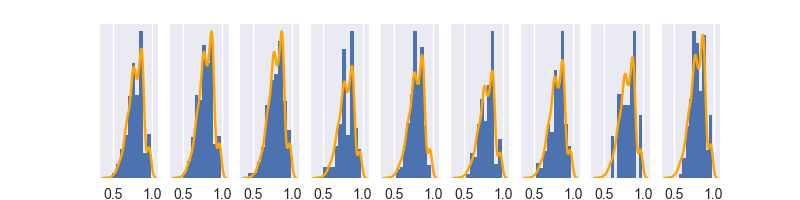

In [186]:
fig = plt.figure(figsize=(8, 2))

for i, cluster in enumerate(cluster_dys):
    fig.add_subplot(1, n_clusters, i+1)
    plt.hist(cluster, normed=True)
    sns.kdeplot(dyssyncs_clean, c='orange')
    plt.yticks([])

The above figure shows each of the clusters dyssynchrony histograms in blue the density plot of all the dyssynchronies in orange.

# Look at simulation parameters <a class="anchor" id="simpplots"></a>
[To table of contents](#toc)

<IPython.core.display.Javascript object>


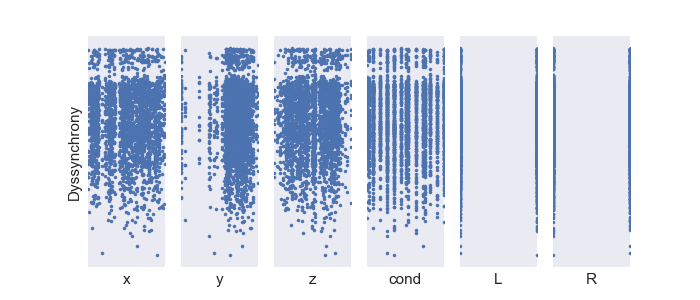

<IPython.core.display.Javascript object>


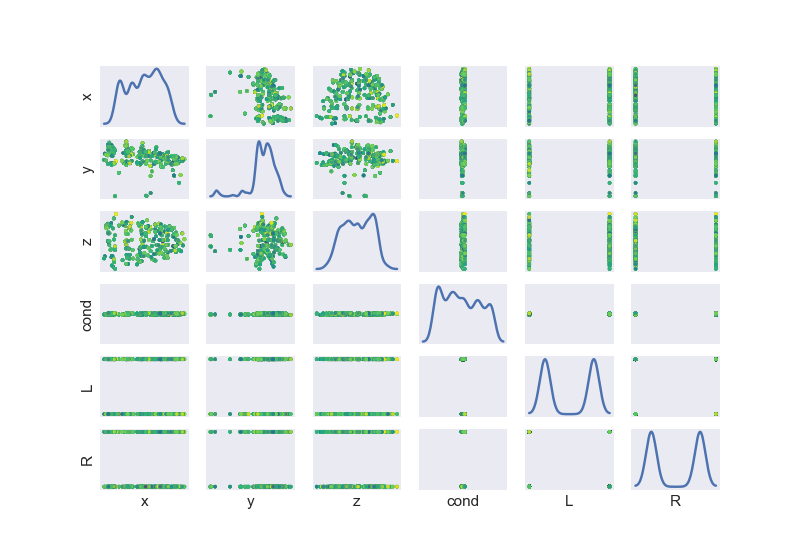

In [172]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 6, 1)
plt.ylabel('Dyssynchrony')
params = patient['eval_values'].values[dyssyncs != 0].copy()
for i, param in enumerate(patient['eval_values']):
    if i > 5:
        break
    plt.subplot(1, 6, i+1)
    plt.xlim([
        patient['eval_values'][param][dyssyncs != 0].min(),
        patient['eval_values'][param][dyssyncs != 0].max()
    ])
    plt.scatter(patient['eval_values'][param][dyssyncs != 0], dyssyncs_clean, s=5)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(patient['eval_values'].columns[i])


    
column_titles = list(patient['eval_values'].columns) + ['Dyssynchrony']

params_df = pd.DataFrame(
    np.concatenate([params, dyssyncs_clean.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

multivariate_scatter(
    data_frame = params_df,
    no_components = 6,
    colour_by = 'Dyssynchrony'
)

# Statistical moments of the curves<a class="anchor" id="smplots"></a>
[To table of contents](#toc)

## PCA with moments using only spatial information
[To table of contents](#toc)

<IPython.core.display.Javascript object>


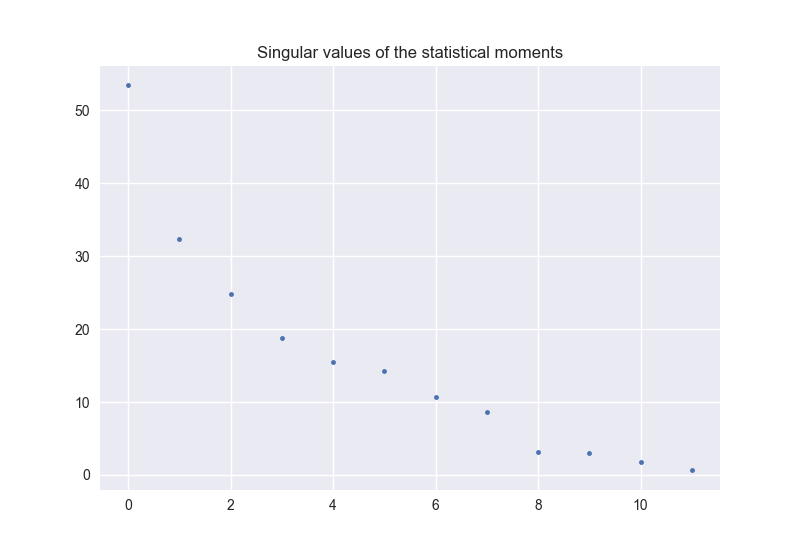

<IPython.core.display.Javascript object>


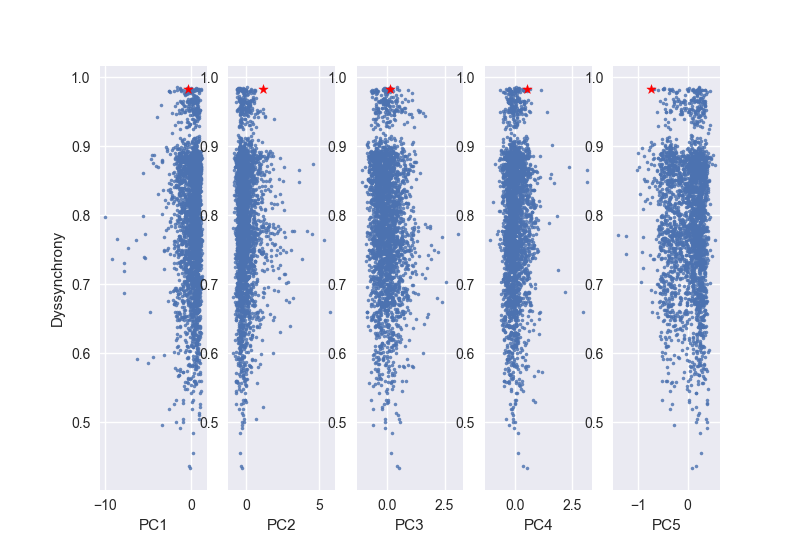

<IPython.core.display.Javascript object>


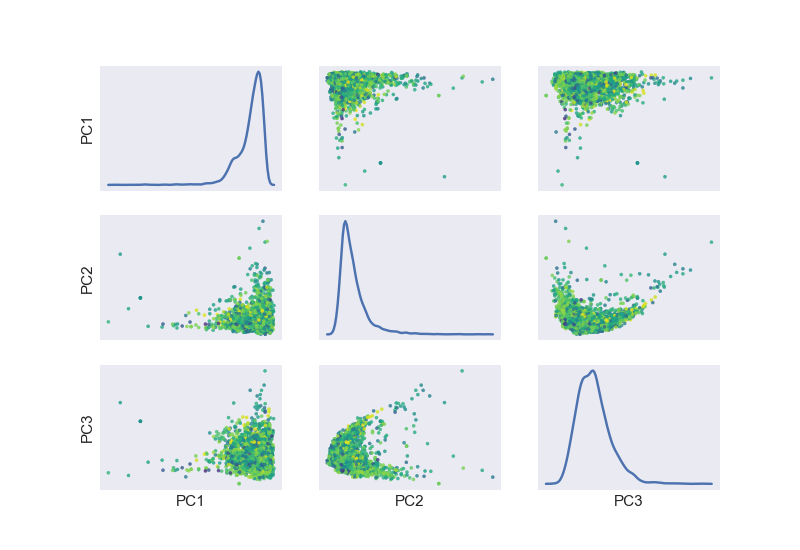

In [192]:
U, S, V = np.linalg.svd(sm_center[:, :12])
pca_matrix = sm_center[:, :12].dot(V.T)
pca_real = (patient_sm[:12] - sm[:, :12].mean(0)).dot(V.T)

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_sm.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

plt.figure()
plt.plot(S, '.')
plt.title('Singular values of the statistical moments')

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_sm,
    real_point = pca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 3,
    colour_by = 'Dyssynchrony'#,
    #real_point = pca_real
)

## PCA with moments using only temporal information
[To table of contents](#toc)

<IPython.core.display.Javascript object>


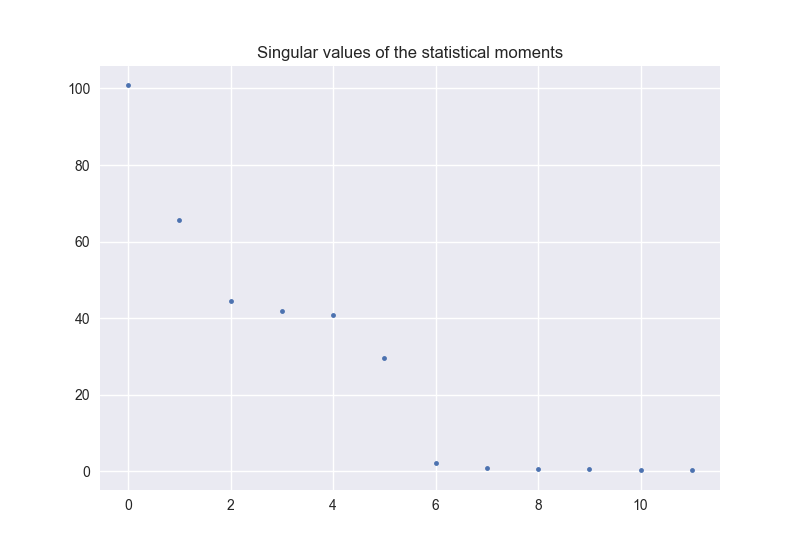

<IPython.core.display.Javascript object>


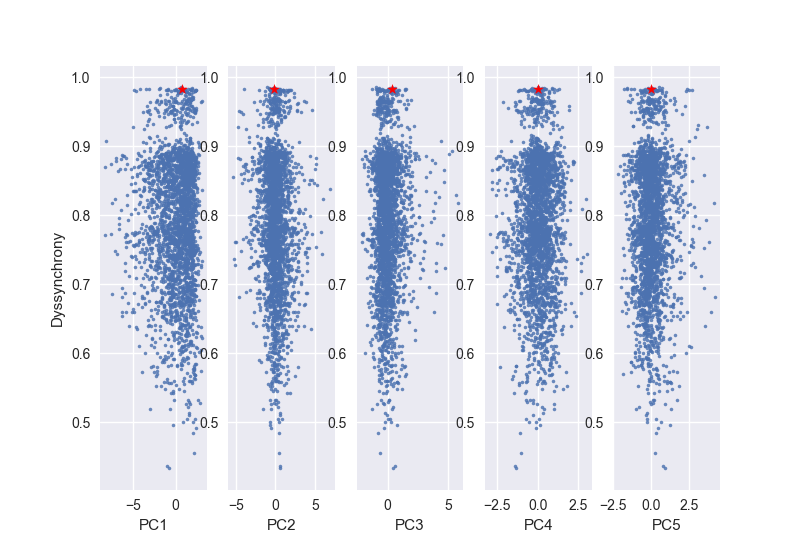

<IPython.core.display.Javascript object>


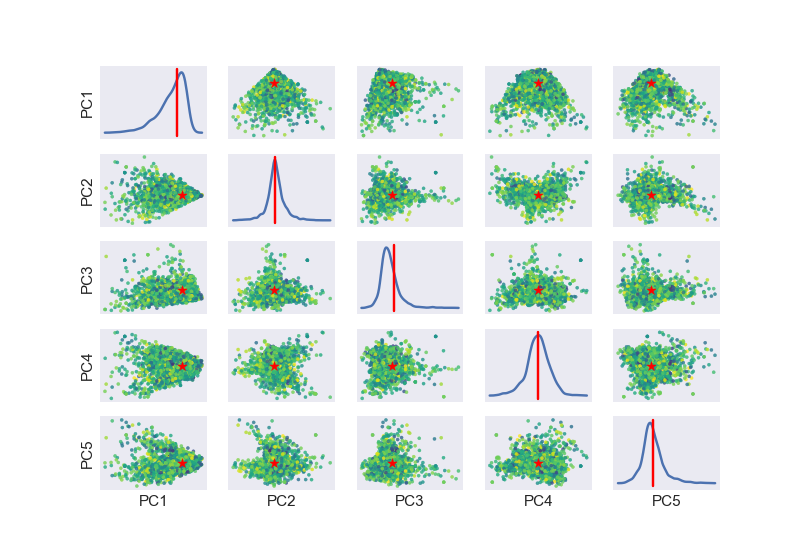

In [174]:
U, S, V = np.linalg.svd(sm_center[:, 12:])
pca_matrix = sm_center[:, 12:].dot(V.T)
pca_real = (patient_sm[12:] - sm[:, 12:].mean(0)).dot(V.T)

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_sm.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

plt.figure()
plt.plot(S, '.')
plt.title('Singular values of the statistical moments')

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_sm,
    real_point = pca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    real_point = pca_real
)

## PCA with moments using both temporal and spatial information
[To table of contents](#toc)

<IPython.core.display.Javascript object>


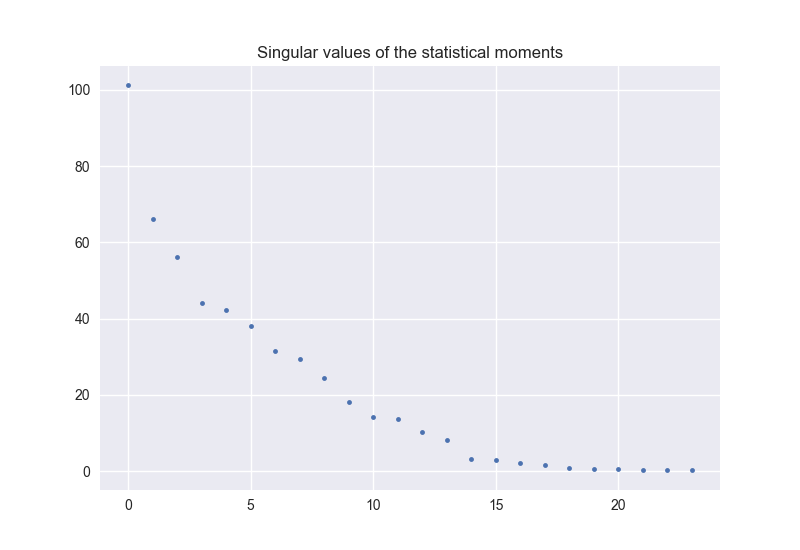

<IPython.core.display.Javascript object>


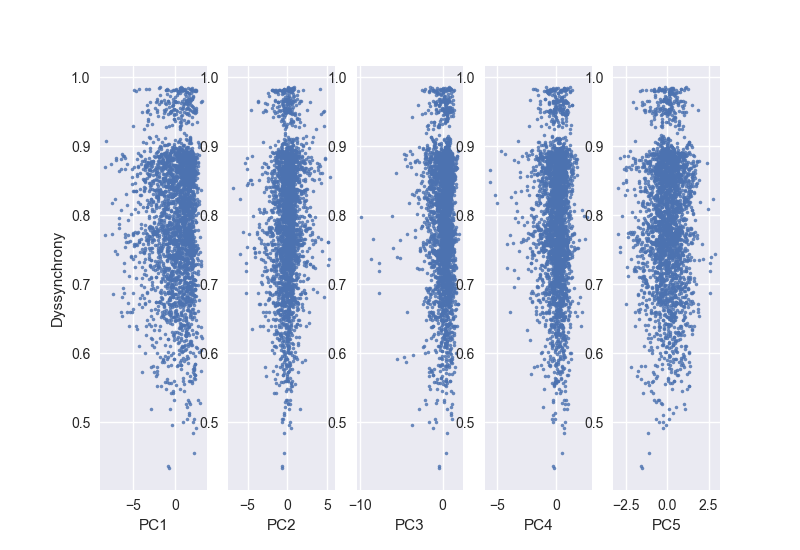

<IPython.core.display.Javascript object>


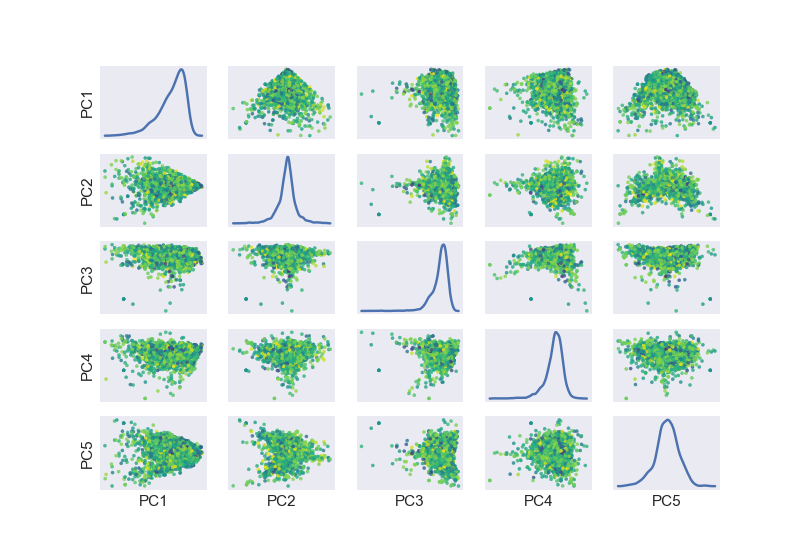

In [187]:
U, S, V = np.linalg.svd(sm_center)
pca_matrix = sm_center[:, :].dot(V.T)
pca_real = (patient_sm - sm.mean(0)).dot(V.T)

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_sm.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

plt.figure()
plt.plot(S, '.')
plt.title('Singular values of the statistical moments')

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_sm,
    # real_point = pca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    #real_point = pca_real
)

# Other features<a class="anchor" id="otherpplots"></a>
[To table of contents](#toc)
### Coming soon

# Machine learning for predictions of dyssynchrony<a class="anchor" id="main_ml"></a>
[To table of contents](#toc)

### For balanced datasets run this
Decreases efficiency, so probably best to avoid it.

In [176]:
dys_min = dyssyncs_clean.min()
dys_max = dyssyncs_clean.max()
dys_range = dys_max - dys_min

n_groups=7

dys_groups = [dys_min + dys_range*i/float(n_groups) for i in range(n_groups + 1)]

ind = np.arange(len(dyssyncs_clean))
ind_groups = [ind[np.logical_and(
    dys_groups[i] < dyssyncs_clean,
    dyssyncs_clean <= dys_groups[i+1]
)] for i in range(n_groups)]

no_points = np.min([
    len(ind_group) for ind_group in ind_groups
])

for group in ind_groups:
    np.random.shuffle(group)
    
indices = np.concatenate([ind_group[:no_points] for ind_group in ind_groups])

# Linear discriminant analysis<a class="anchor" id="lda"></a>
[To table of contents](#toc)

In [177]:
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', store_covariance=True)
# Create different classes
classes = (dyssyncs_clean > 0.9).astype(int) \
        + (dyssyncs_clean > 0.8).astype(int) \
        + (dyssyncs_clean > 0.7).astype(int)
lda_transformed = lda.fit(dm_center[:300], classes[:300])
lda_transformed = lda.transform(dm_center[300:])

<IPython.core.display.Javascript object>


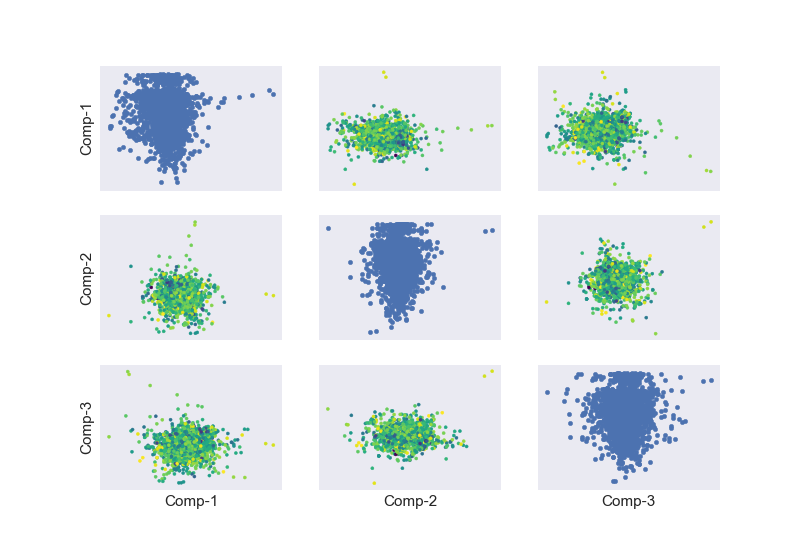

In [178]:
plt.figure()
n_comp = classes.max()
for i in range(n_comp):
    for j in range(n_comp):
        plt.subplot(n_comp, n_comp, j + n_comp*i + 1)
        if i == j:
            plt.scatter(lda_transformed[:, i], dyssyncs_clean[300:], s=10)
        else:
            plt.scatter(lda_transformed[:, i], lda_transformed[:, j], c=dyssyncs_clean[300:], cmap='viridis', s=5)
        plt.yticks([])
        plt.xticks([])
        if i == n_comp-1:
            plt.xlabel('Comp-{}'.format(j+1))
        if j == 0:
            plt.ylabel('Comp-{}'.format(i+1))

The scatterplots on the main diagonal in the figure above have LDA component response on the first axis and dyssynchrony on the second axis.

# Kernel Ridge Regression for dyssynchrony<a class="anchor" id="krr"></a>
[To table of contents](#toc)

### Using only spatial information<a class="anchor" id="krr_spat"></a>
[To table of contents](#toc)

In [179]:
gammas = np.logspace(-4, -1, 15)
alphas = np.logspace(-3, 0, 8)
cv_score = np.array([[ 
    np.mean(
        cross_val_score(
            KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha), 
            dm_center[:, :2*dm_center.shape[1]/3], 
            dyssyncs_clean[:], 
            cv=5, 
            scoring='neg_mean_squared_error'
        )
    ) for gamma in gammas]
    for alpha in alphas
])

print('Optimal score is {}, guessing mean gives {}'.format(
    np.sqrt(-1*cv_score.max()), 
    np.sqrt(np.mean((dyssyncs - dyssyncs.mean())**2))
))

opt_gamma = 0
opt_alpha = 0
for i, gamma in enumerate(gammas):
    for j, alpha in enumerate(alphas):
        if cv_score[j, i] == cv_score.max():
            opt_gamma = gamma
            opt_alpha = alpha

print('Optimal alpha={}, optimal gamma={}'.format(
    opt_alpha,
    opt_gamma
))

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


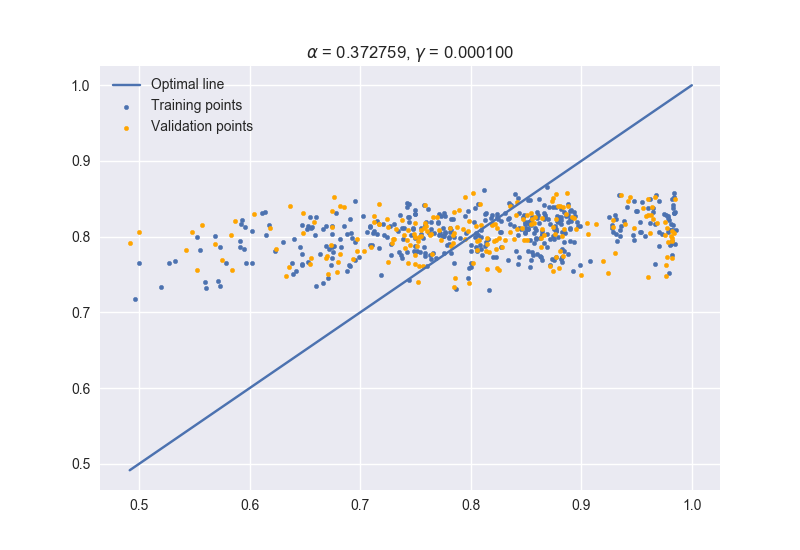

In [363]:
kernel_ridge = KernelRidge(kernel='rbf', gamma=opt_gamma, alpha=opt_alpha)
kernel_ridge.fit(dm_center[:400, :2*dm_center.shape[1]/3], dyssyncs_clean[:400])
train_val = kernel_ridge.predict(dm_center[:400, :2*dm_center.shape[1]/3])
test_val = kernel_ridge.predict(dm_center[400:, :2*dm_center.shape[1]/3])

plt.figure()
plt.scatter(dyssyncs_clean[:400], train_val, s=10)
plt.scatter(dyssyncs_clean[400:], test_val, s=10, color='orange')
plt.plot([dyssyncs_clean.min(), 1], [dyssyncs_clean.min(), 1])
plt.legend(['Optimal line', 'Training points', 'Validation points'])
plt.title('$\\alpha$ = {:4f}, $\\gamma$ = {:4f}'.format(opt_alpha, opt_gamma))

## Using the exponential kernel
WARNING: VERY SLOW!

In [ ]:
from learning import *

alphas = np.logspace(-1, 2, 4)
sigmas = np.logspace(-4, 1, 4)

### Using temporal information from velocities as well<a class="anchor" id="krr_temp"></a>
[To table of contents](#toc)

<IPython.core.display.Javascript object>


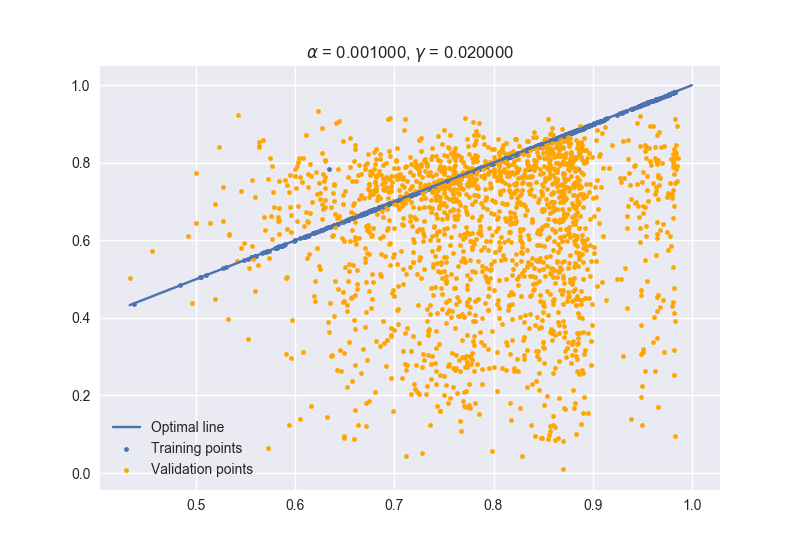

In [195]:
gammas = np.logspace(-3, -2, 3)
alphas = np.logspace(-3, 0, 1)
"""
cv_score = np.array([[ 
    np.mean(
        cross_val_score(
            KernelRidge(kernel='laplacian', gamma=gamma, alpha=alpha), 
            dmv_center[:, :], 
            dyssyncsv[:], 
            cv=2, 
            scoring='neg_mean_squared_error'
        )
    ) for gamma in gammas]
    for alpha in alphas
])

print('Optimal score is {}, guessing mean gives {}'.format(
    np.sqrt(-1*cv_score.max()), 
    np.sqrt(np.mean((dyssyncs - dyssyncs.mean())**2))
))

opt_gamma = 0
opt_alpha = 0
for i, gamma in enumerate(gammas):
    for j, alpha in enumerate(alphas):
        if cv_score[j, i] == cv_score.max():
            opt_gamma = gamma
            opt_alpha = alpha

print('Optimal alpha={}, optimal gamma={}'.format(
    opt_alpha,
    opt_gamma
))
"""
opt_gamma = 0.02
opt_alpha=0.001

kernel_ridge = KernelRidge(kernel='laplacian', gamma=opt_gamma, alpha=opt_alpha)
kernel_ridge.fit(dmv_center[:1000, :], dyssyncs_clean[:1000])
train_val = kernel_ridge.predict(dmv_center[:1000, :])
test_val = kernel_ridge.predict(dmv_center[1000:, :])

plt.figure()
plt.scatter(dyssyncsv[:1000], train_val, s=10)
plt.scatter(dyssyncsv[1000:], test_val, s=10, color='orange')
plt.plot([dyssyncsv.min(), 1], [dyssyncsv.min(), 1])
plt.legend(['Optimal line', 'Training points', 'Validation points'])
plt.title('$\\alpha$ = {:4f}, $\\gamma$ = {:4f}'.format(opt_alpha, opt_gamma))

### Using statistical moments<a class="anchor" id="krr_sm"></a>
[To table of contents](#toc)

Optimal score is 0.0952728673743, guessing mean gives 0.114786789824
Optimal alpha=0.0193069772888, optimal gamma=0.0464158883361


<IPython.core.display.Javascript object>


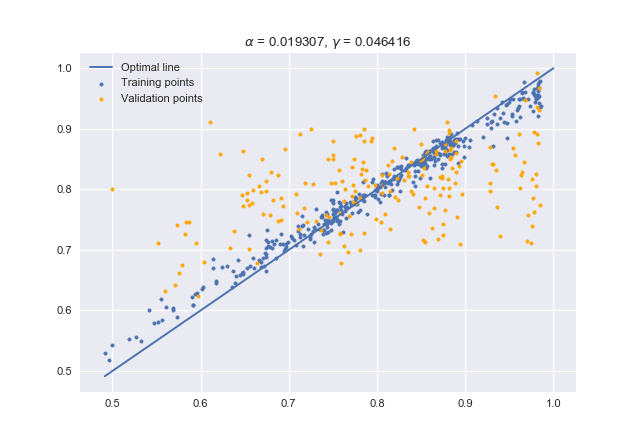

In [213]:
gammas = np.logspace(-3, 2, 10)
alphas = np.logspace(-3, 0, 8)
cv_score = np.array([[ 
    np.mean(
        cross_val_score(
            KernelRidge(kernel='laplacian', gamma=gamma, alpha=alpha), 
            sm_center[:, :], 
            dyssyncs_sm[:], 
            cv=5, 
            scoring='neg_mean_squared_error'
        )
    ) for gamma in gammas]
    for alpha in alphas
])

print('Optimal score is {}, guessing mean gives {}'.format(
    np.sqrt(-1*cv_score.max()), 
    np.sqrt(np.mean((dyssyncs - dyssyncs.mean())**2))
))

opt_gamma = 0
opt_alpha = 0
for i, gamma in enumerate(gammas):
    for j, alpha in enumerate(alphas):
        if cv_score[j, i] == cv_score.max():
            opt_gamma = gamma
            opt_alpha = alpha

print('Optimal alpha={}, optimal gamma={}'.format(
    opt_alpha,
    opt_gamma
))

kernel_ridge = KernelRidge(kernel='laplacian', gamma=opt_gamma, alpha=opt_alpha)
kernel_ridge.fit(sm_center[:400, :], dyssyncs_sm[:400])
train_val = kernel_ridge.predict(sm_center[:400, :])
test_val = kernel_ridge.predict(sm_center[400:, :])

plt.figure()
plt.scatter(dyssyncs_sm[:400], train_val, s=10)
plt.scatter(dyssyncs_sm[400:], test_val, s=10, color='orange')
plt.plot([dyssyncsv.min(), 1], [dyssyncsv.min(), 1])
plt.legend(['Optimal line', 'Training points', 'Validation points'])
plt.title('$\\alpha$ = {:4f}, $\\gamma$ = {:4f}'.format(opt_alpha, opt_gamma))

## Using principal components

Optimal score is 0.0923582428919, guessing mean gives 0.114786789824
14 PCs, optimal alpha=0.00719685673001, optimal gamma=0.0138949549437


<IPython.core.display.Javascript object>


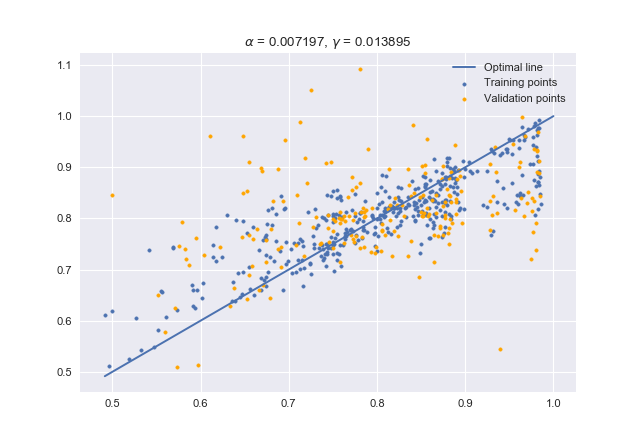

In [223]:
gammas = np.logspace(-4, 2, 15)
alphas = np.logspace(-3, 0, 8)
no_pcs = np.arange(9, 15)


dmv_no_z = dmv_center[:, [True]*2*resampling_no + [False]*resampling_no + [True]*3*resampling_no]

U, S, V = np.linalg.svd(dmv_no_z)
pc_matrix = dmv_no_z.dot(V.T)



cv_score = np.array([[[ 
            np.mean(
                cross_val_score(
                    KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha), 
                    pc_matrix[:, :no_pc], 
                    dyssyncsv[:], 
                    cv=5, 
                    scoring='neg_mean_squared_error'
                )
            ) for gamma in gammas
        ] for alpha in alphas
    ] for no_pc in no_pcs
])

print('Optimal score is {}, guessing mean gives {}'.format(
    np.sqrt(-1*cv_score.max()), 
    np.sqrt(np.mean((dyssyncs - dyssyncs.mean())**2))
))

opt_gamma = 0
opt_alpha = 0
opt_pcs = 0
for i, gamma in enumerate(gammas):
    for j, alpha in enumerate(alphas):
        for k, no_pc in enumerate(no_pcs):
            if cv_score[k, j, i] == cv_score.max():
                opt_gamma = gamma
                opt_alpha = alpha
                opt_pcs = no_pc
                break

print('{} PCs, optimal alpha={}, optimal gamma={}'.format(
    opt_pcs,
    opt_alpha,
    opt_gamma
))

kernel_ridge = KernelRidge(kernel='rbf', gamma=opt_gamma, alpha=opt_alpha)
kernel_ridge.fit(pc_matrix[:400, :opt_pcs], dyssyncsv[:400])
train_val = kernel_ridge.predict(pc_matrix[:400, :opt_pcs])
test_val = kernel_ridge.predict(pc_matrix[400:, :opt_pcs])

plt.figure()
plt.scatter(dyssyncsv[:400], train_val, s=10)
plt.scatter(dyssyncsv[400:], test_val, s=10, color='orange')
plt.plot([dyssyncsv.min(), 1], [dyssyncsv.min(), 1])
plt.legend(['Optimal line', 'Training points', 'Validation points'])
plt.title('$\\alpha$ = {:4f}, $\\gamma$ = {:4f}'.format(opt_alpha, opt_gamma))

## LASSO to see what features are most important

<IPython.core.display.Javascript object>


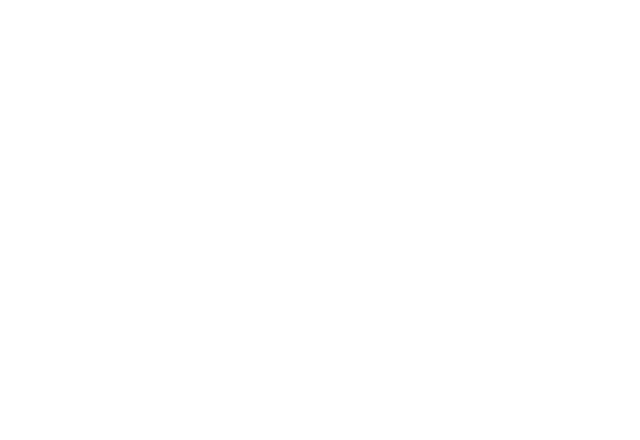

0.0102234300331


In [226]:
gammas = np.logspace(-3, 2, 10)
alphas = np.logspace(-3, -0, 8)
cv_lasso = ElasticNetCV(normalize=False, cv=5)
cv_lasso.fit(pc_matrix, dyssyncsv)

plt.figure()
plt.plot(cv_lasso.coef_)
print(np.mean((cv_lasso.predict(pc_matrix) - dyssyncsv)**2))

<IPython.core.display.Javascript object>


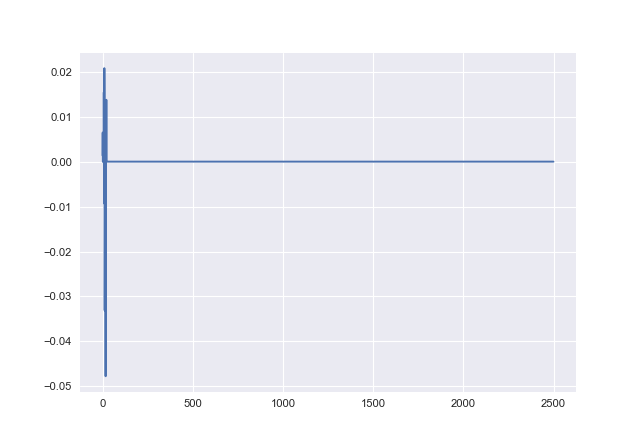

In [229]:
plt.figure()
plt.plot(cv_lasso.coef_)